# Transfer Learning for Multi-Class Classification


This notebook is an implementation of transfer learning approach by using multi-class weather dataset for image classification task.

The dataset consists of a total of 1125 images which are maually labeled as cloudy, sunrise, rainy and sun shine. I will use pre-trained models which are ResNet and InceptionV3 available from Keras.

With transfer learning, instead of starting the learning process from scratch, we start from patterns that have been learned when solving a new related problem. So we reuse initial and middle layers of our pre-trained model to re-train only final layers for our new task. A pre-trained model denotes a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve.

![transfer-learning](image-tf.png)





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Data preprocessing

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42    
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.


2022-05-06 18:00:41.404599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First nine images and labels from training set: 

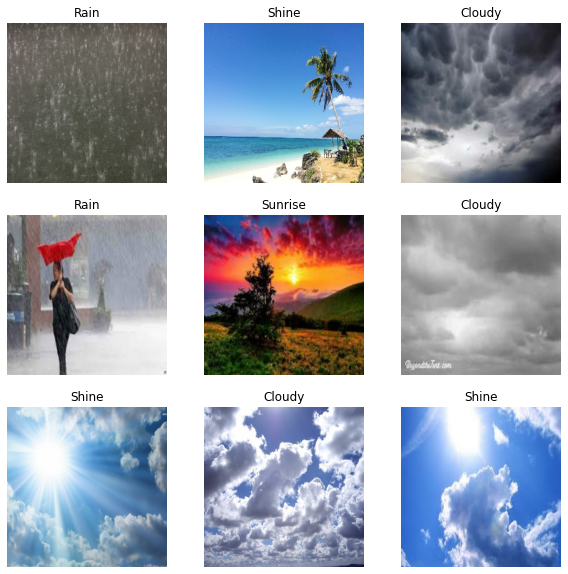

In [3]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move some of them to a test set.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 2


### Configure dataset for performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

If the dataset is not too large, introducing sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping, helps with overfitting.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

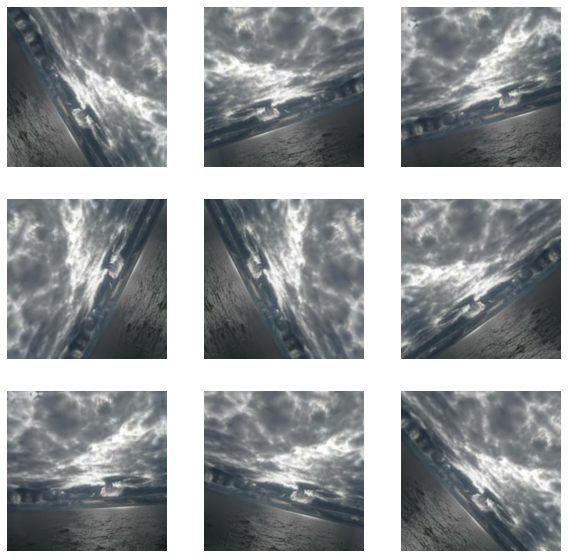

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescaling

Rescale pixel values by using the preprocessing method included with the models.

In [8]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input
preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

# Resnet50

## Create the base model from pre-trained weights

 By specifying the **include_top=False** argument, We load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [9]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

### Freeze the base model

In [10]:
base_model.trainable=False

### Build a model

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the Sequential layer.

- To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single vector per image.
- Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.
- Apply a last `tf.keras.layers.Dense` layer with softmax activation to apply multi-class classification.

In [11]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_resnet),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

### Compile and Train the Model

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
29/29 [==============================] - 86s 3s/step - loss: 0.9106 - accuracy: 0.6233 - val_loss: 0.3291 - val_accuracy: 0.9441
Epoch 2/10
29/29 [==============================] - 89s 3s/step - loss: 0.3298 - accuracy: 0.8956 - val_loss: 0.2005 - val_accuracy: 0.9503
Epoch 3/10
29/29 [==============================] - 87s 3s/step - loss: 0.2209 - accuracy: 0.9300 - val_loss: 0.1275 - val_accuracy: 0.9689
Epoch 4/10
29/29 [==============================] - 87s 3s/step - loss: 0.1646 - accuracy: 0.9433 - val_loss: 0.1505 - val_accuracy: 0.9379
Epoch 5/10
29/29 [==============================] - 82s 3s/step - loss: 0.1452 - accuracy: 0.9422 - val_loss: 0.1342 - val_accuracy: 0.9565
Epoch 6/10
29/29 [==============================] - 84s 3s/step - loss: 0.1216 - accuracy: 0.9633 - val_loss: 0.0999 - val_accuracy: 0.9565
Epoch 7/10
29/29 [==============================] - 87s 3s/step - loss: 0.1202 - accuracy: 0.9611 - val_loss: 0.1299 - val_accuracy: 0.9441
Epoch 8/10
29/29 [==

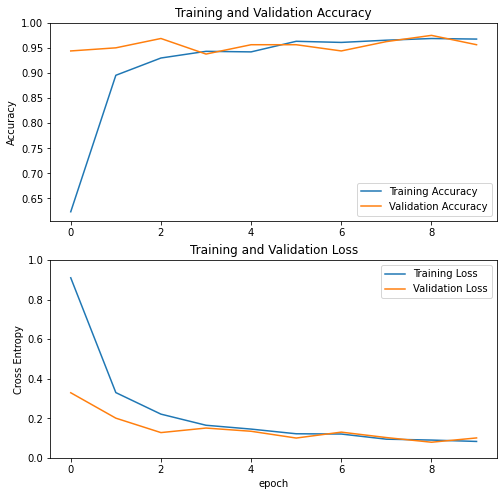

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier.

### Unfreeze the Top Layers of Base Model

Unfreeze the `base_model` and set the bottom layers to be un-trainable.

In [14]:
base_model.trainable = True

In [15]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


### Compile and Continue Training The model

In [17]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
29/29 [==============================] - 146s 5s/step - loss: 0.1333 - accuracy: 0.9600 - val_loss: 0.1268 - val_accuracy: 0.9627
Epoch 11/20
29/29 [==============================] - 147s 5s/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 0.0991 - val_accuracy: 0.9752
Epoch 12/20
29/29 [==============================] - 151s 5s/step - loss: 0.0915 - accuracy: 0.9689 - val_loss: 0.0444 - val_accuracy: 0.9876
Epoch 13/20
29/29 [==============================] - 151s 5s/step - loss: 0.0843 - accuracy: 0.9767 - val_loss: 0.0794 - val_accuracy: 0.9814
Epoch 14/20
29/29 [==============================] - 144s 5s/step - loss: 0.0490 - accuracy: 0.9878 - val_loss: 0.0596 - val_accuracy: 0.9876
Epoch 15/20
29/29 [==============================] - 143s 5s/step - loss: 0.0655 - accuracy: 0.9822 - val_loss: 0.0891 - val_accuracy: 0.9752
Epoch 16/20
29/29 [==============================] - 142s 5s/step - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.0954 - val_accuracy: 0.9752
Epoch 

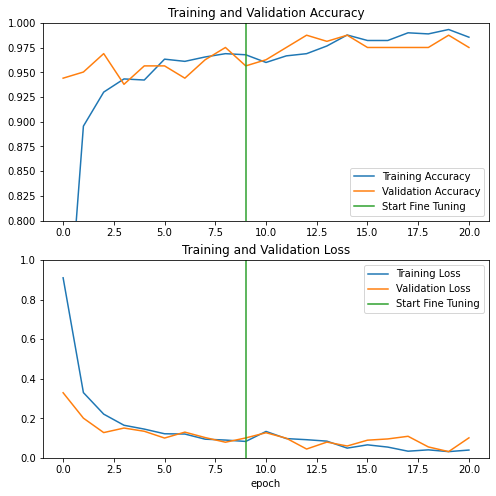

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediciton

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 5s 2s/step - loss: 0.0177 - accuracy: 1.0000
Test accuracy : 1.0


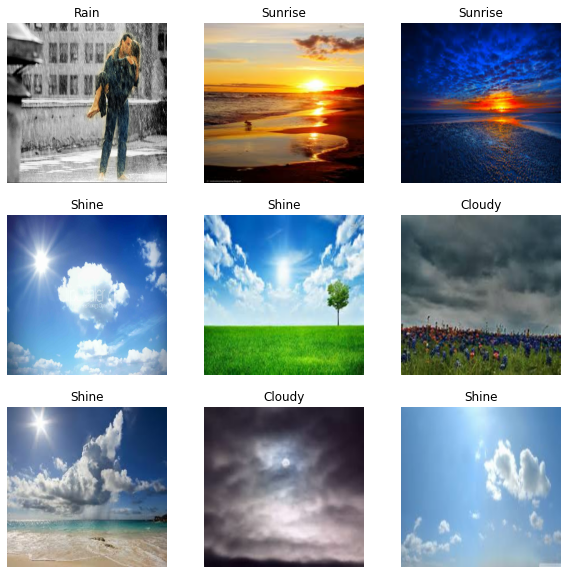

In [20]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## InceptionV3

### Create the base model and model 

In [21]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

base_model.trainable=False

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_inception),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

### Compile and Train the Model

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
29/29 [==============================] - 35s 1s/step - loss: 1.1177 - accuracy: 0.5122 - val_loss: 0.7012 - val_accuracy: 0.8199
Epoch 2/10
29/29 [==============================] - 33s 1s/step - loss: 0.6105 - accuracy: 0.8022 - val_loss: 0.4357 - val_accuracy: 0.8882
Epoch 3/10
29/29 [==============================] - 34s 1s/step - loss: 0.4075 - accuracy: 0.8678 - val_loss: 0.3226 - val_accuracy: 0.9193
Epoch 4/10
29/29 [==============================] - 34s 1s/step - loss: 0.3380 - accuracy: 0.8756 - val_loss: 0.2642 - val_accuracy: 0.9317
Epoch 5/10
29/29 [==============================] - 44s 2s/step - loss: 0.2590 - accuracy: 0.9233 - val_loss: 0.2882 - val_accuracy: 0.8944
Epoch 6/10
29/29 [==============================] - 41s 1s/step - loss: 0.2368 - accuracy: 0.9233 - val_loss: 0.2523 - val_accuracy: 0.9255
Epoch 7/10
29/29 [==============================] - 42s 1s/step - loss: 0.2252 - accuracy: 0.9256 - val_loss: 0.2695 - val_accuracy: 0.9130
Epoch 8/10
29/29 [==

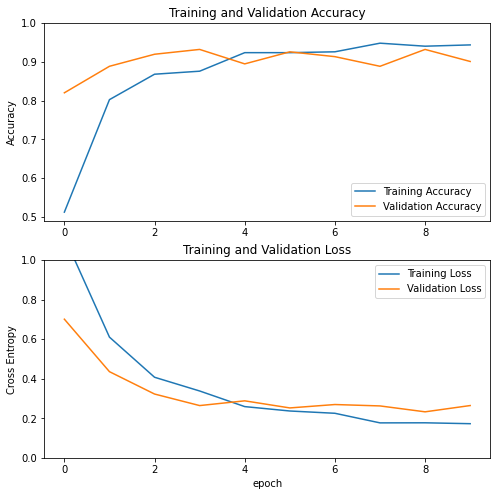

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

In [24]:
base_model.trainable = True

# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
29/29 [==============================] - 98s 3s/step - loss: 0.8804 - accuracy: 0.6344 - val_loss: 0.2892 - val_accuracy: 0.9130
Epoch 11/20
29/29 [==============================] - 94s 3s/step - loss: 0.4539 - accuracy: 0.8367 - val_loss: 0.2897 - val_accuracy: 0.9068
Epoch 12/20
29/29 [==============================] - 96s 3s/step - loss: 0.3397 - accuracy: 0.8922 - val_loss: 0.2340 - val_accuracy: 0.9255
Epoch 13/20
29/29 [==============================] - 96s 3s/step - loss: 0.2466 - accuracy: 0.9222 - val_loss: 0.2271 - val_accuracy: 0.9379
Epoch 14/20
29/29 [==============================] - 97s 3s/step - loss: 0.2113 - accuracy: 0.9378 - val_loss: 0.1711 - val_accuracy: 0.9627
Epoch 15/20
29/29 [==============================] - 98s 3s/step - loss: 0.1908 - accuracy: 0.9444 - val_loss: 0.1437 - val_accuracy: 0.9503
Epoch 16/20
29/29 [==============================] - 98s 3s/step - loss: 0.1809 - accuracy: 0.9389 - val_loss: 0.1774 - val_accuracy: 0.9565
Epoch 17/20
2

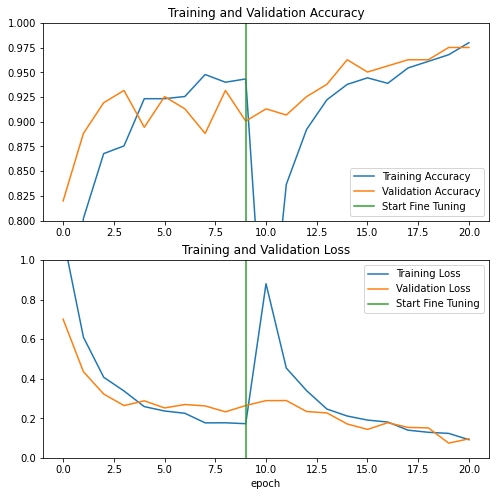

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediciton

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 770ms/step - loss: 0.1692 - accuracy: 0.9844
Test accuracy : 0.984375


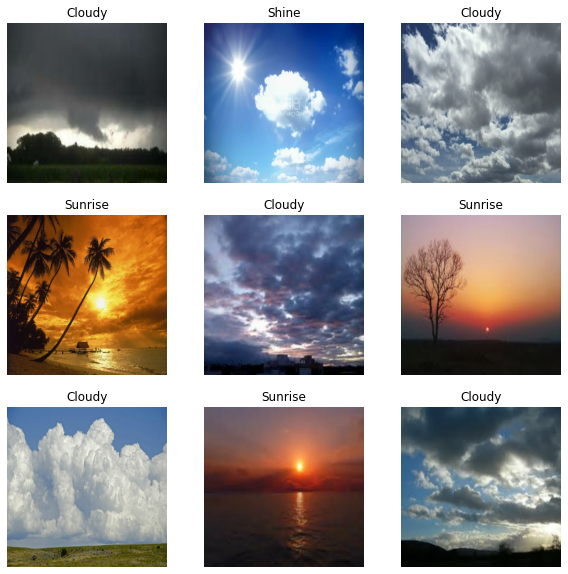

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")